In [51]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FuncFormatter

from collections import defaultdict
from itertools import cycle

In [52]:
def gaussian(x, mean, std_dev):
    return (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)

In [53]:
def find_gaussian_range(mean, std_dev, threshold=0.01):
    """Find the x-range for the Gaussian function to reach the y-value threshold."""
    low_x = mean - np.sqrt(-2 * std_dev**2 * np.log(std_dev * np.sqrt(2 * np.pi) * threshold))
    high_x = mean + np.sqrt(-2 * std_dev**2 * np.log(std_dev * np.sqrt(2 * np.pi) * threshold))
    return low_x, high_x

In [54]:
def plot_gaussian_distribution(dataframe, model_name):
    fig, ax = plt.subplots(figsize=(10, 6))
    min_support_values = dataframe['Minimum Support'].unique()
    colors = cm.viridis(np.linspace(0, 1, len(min_support_values)))

    for idx, (min_support, group) in enumerate(dataframe.groupby('Minimum Support')):
        std_dev = group['Match Percentage'].std()
        mean_match_percentage = dataframe[dataframe['Minimum Support'] == min_support]['Match Percentage'].mean()

        if np.isnan(std_dev):
            continue

        x = np.linspace(0, 100, 1000)
        y = gaussian(x, mean_match_percentage, std_dev)

        color = colors[idx % len(colors)]
        ax.plot(x, y, label=f'Support range: {min_support} : {min_support + 20}')
        ax.fill_between(x, y, color=color, alpha=0.1)

    ax.set_title(f'Gaussian Distribution of Equation Match Percentage for {model_name}')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlabel('Equation Match Percentage')
    ax.set_ylabel('Probability Density')

    return fig

In [55]:
def plot_gaussian_distribution_multiple_models(dataframe, modelname_visible=False):
    fig = plt.figure(figsize=(14, 5))  # Reduce the height of the figure
    gs = GridSpec(1, 2, width_ratios=[3, 1])  # Create grid with space for legend
    ax = fig.add_subplot(gs[0])  # Create main plot area

    models = dataframe['Model'].unique()
    unique_combinations = dataframe.drop_duplicates(subset=['Model', 'Minimum Support'])
    num_lines = len(unique_combinations)
    colors = cm.viridis(np.linspace(0, 1, num_lines))  # Generate a global color map

    # Define line styles
    linestyles = [(0, (10, 1, 1, 1, 1, 1)), '-', '--', ':']  # Solid, dashed, dotted, custom pattern with line and three dots
    linestyle_cycle = cycle(linestyles)  # Cycle through line styles
    model_linestyles = {model: next(linestyle_cycle) for model in models}  # Assign a unique linestyle to each model

    # Determine the global x-range
    global_low_x = float('inf')
    global_high_x = float('-inf')
    
    for model_name in models:
        model_data = dataframe[dataframe['Model'] == model_name]
        for min_support in model_data['Minimum Support'].unique():
            group = model_data[model_data['Minimum Support'] == min_support]
            if group.empty:
                continue
            std_dev = group['Match Percentage'].std()
            mean_match_percentage = group['Match Percentage'].mean()
            if np.isnan(std_dev):
                continue
            low_x, high_x = find_gaussian_range(mean_match_percentage, std_dev)
            global_low_x = min(global_low_x, low_x)
            global_high_x = max(global_high_x, high_x)
    
    x = np.linspace(global_low_x, global_high_x, 1000)
    color_idx = 0
    legend_handles = defaultdict(list)
    legend_labels = defaultdict(list)
    annotations = []

    for model_name in models:
        model_data = dataframe[dataframe['Model'] == model_name]
        linestyle = model_linestyles[model_name]  # Get the unique linestyle for the model

        for min_support in model_data['Minimum Support'].unique():
            group = model_data[model_data['Minimum Support'] == min_support]
            if group.empty:
                continue
            
            std_dev = group['Match Percentage'].std()
            mean_match_percentage = group['Match Percentage'].mean()

            if np.isnan(std_dev):
                continue

            y = gaussian(x, mean_match_percentage, std_dev)

            color = colors[color_idx]
            color_idx += 1

            line, = ax.plot(x, y, color=color, linestyle=linestyle, label=f'Support range: {min_support} : {min_support + 20}')
            ax.fill_between(x, y, color=color, alpha=0.1)
            legend_handles[model_name].append(line)
            legend_labels[model_name].append(f'Support range: {min_support} : {min_support + 20}')
            
            if modelname_visible:
                # Annotate the peak of the Gaussian curve with the model name
                peak_y = max(y)
                annotations.append((mean_match_percentage, peak_y, model_name, color))

    if modelname_visible:
        # Adjust annotations to avoid overlap
        annotations.sort(key=lambda x: x[1], reverse=True)  # Sort by y-value (peak height)
        offset = 0.05  # Offset value for text
        adjusted_annotations = []
        for i, (x, y, model_name, color) in enumerate(annotations):
            adjusted_y = y
            if i > 0 and abs(y - adjusted_annotations[-1][1]) < offset:
                # Check both directions for the best adjustment
                if adjusted_y - offset > 0 and (i == 1 or abs((adjusted_y - offset) - adjusted_annotations[-2][1]) >= offset):
                    adjusted_y -= offset
                else:
                    adjusted_y += offset
            adjusted_annotations.append((x, adjusted_y, model_name, color))
            ax.text(x, adjusted_y, model_name, color=color, ha='center', va='bottom', fontproperties=FontProperties(weight='bold'))

    ax.set_title('Gaussian Distribution of Equation Match Percentage for Various Models')
    ax.set_xlabel('Equation Match Percentage')
    ax.set_ylabel('Probability Density')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))
    
    # Custom legend handling
    legend_entries = []
    bold_font = FontProperties(weight='bold')  # Define bold font properties
    for model_name in models:
        legend_entries.append((plt.Line2D([0], [0], color='white', lw=0), model_name))
        for handle, label in zip(legend_handles[model_name], legend_labels[model_name]):
            legend_entries.append((handle, label))

    legend_ax = fig.add_subplot(gs[1])  # Create space for legend
    legend_ax.axis('off')  # Hide the legend subplot axis

    # Create custom legend entries
    handles = []
    labels = []
    for entry in legend_entries:
        if entry[1] in models:
            # Add bold text for model names
            handles.append(entry[0])
            labels.append(entry[1])
        else:
            handles.append(entry[0])
            labels.append(entry[1])

    # Add the legend with custom properties
    custom_legend = legend_ax.legend(handles, labels, loc='upper left', frameon=False)
    for text in custom_legend.get_texts():
        if text.get_text() in models:
            text.set_fontproperties(bold_font)  # Apply bold font to model names

    fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to fit everything nicely and reduce right padding
    return fig

In [56]:
def plot_mean_match_percentage(evaluation_summary, show_std_shaded=True):
    filtered_df = evaluation_summary[
        (evaluation_summary['Minimum Support'].between(-30, 10)) & 
        ((evaluation_summary['Maximum Support'] - evaluation_summary['Minimum Support']) == 20)
    ]

    grouped = filtered_df.groupby(['Minimum Support', 'Model'])['Match Percentage']
    mean_match_percentages = grouped.mean().reset_index()
    std_match_percentages = grouped.std().reset_index()

    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Set up the Viridis colormap
    colormap = plt.cm.viridis
    models = mean_match_percentages['Model'].unique()
    colors = colormap(np.linspace(0, 1, len(models)))

    for idx, model in enumerate(models):
        model_data = mean_match_percentages[mean_match_percentages['Model'] == model]
        model_std_data = std_match_percentages[std_match_percentages['Model'] == model]
        ax.plot(model_data['Minimum Support'], model_data['Match Percentage'], label=model, color=colors[idx])
        if show_std_shaded:
            ax.fill_between(
                model_data['Minimum Support'],
                model_data['Match Percentage'] - model_std_data['Match Percentage'],
                model_data['Match Percentage'] + model_std_data['Match Percentage'],
                color=colors[idx],
                alpha=0.3
            )

    def format_x_axis(value, tick_number):
        return f'{value}:{value + 20}'
    
    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_x_axis))

    ax.set_xlabel('Support (minimum : maximum)')
    ax.set_ylabel('Mean Match Percentage')
    ax.set_title('Mean Match Percentage for Different Models')

    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))
    ax.legend()

    return fig

In [57]:
evaluation_path = '../evaluation/'
evaluation_summary_path = f'{evaluation_path}evaluation_summary.csv'

evaluation_summary = pd.read_csv(evaluation_summary_path)

In [58]:
evaluation_summary.head()

,Model,Dataset,Skeleton Encoder Layers,Loss Version,Minimum Support,Maximum Support,Total Entries,Match Sum,Match Percentage,Number of Samples
0,mmsr_se1_oldloss,train_nc,1.0,old,-40.0,-30.0,214,1,0.467290,500.0
1,mmsr_se1_oldloss,train_nc,1.0,old,-40.0,-30.0,212,1,0.471698,500.0
2,mmsr_se1_oldloss,train_nc,1.0,old,-40.0,-30.0,212,1,0.471698,500.0
3,mmsr_se1_oldloss,train_nc,1.0,old,-40.0,-30.0,213,1,0.469484,500.0
4,mmsr_se1_oldloss,train_nc,1.0,old,-40.0,-30.0,213,1,0.469484,500.0


In [59]:
evaluation_summary['Model'].unique()

array(['mmsr_se1_oldloss', 'mmsr_se5_newloss', 'mmsr_se5_oldloss', 'nsr',
       'self_trained_nsr'], dtype=object)

In [60]:
mmsr_newloss_eval = evaluation_summary[evaluation_summary['Model'] == 'mmsr_se5_newloss']
mmsr_newloss_eval.head()

,Model,Dataset,Skeleton Encoder Layers,Loss Version,Minimum Support,Maximum Support,Total Entries,Match Sum,Match Percentage,Number of Samples
912,mmsr_se5_newloss,train_nc,5.0,new,-40.0,-30.0,212,1,0.471698,500.0
913,mmsr_se5_newloss,train_nc,5.0,new,-40.0,-30.0,212,1,0.471698,500.0
914,mmsr_se5_newloss,train_nc,5.0,new,-40.0,-30.0,212,0,0.000000,500.0
915,mmsr_se5_newloss,train_nc,5.0,new,-40.0,-30.0,212,0,0.000000,500.0
916,mmsr_se5_newloss,train_nc,5.0,new,-40.0,-30.0,211,1,0.473934,500.0


In [61]:
#TO CHANGE: % 20 so values never get sampled from the same range
evaluation_summary[(evaluation_summary['Model'] == 'mmsr_se5_newloss') & (evaluation_summary['Minimum Support'] % 10 == 0)]

,Model,Dataset,Skeleton Encoder Layers,Loss Version,Minimum Support,Maximum Support,Total Entries,Match Sum,Match Percentage,Number of Samples
912,mmsr_se5_newloss,train_nc,5.0,new,-40.0,-30.0,212,1,0.471698,500.0
913,mmsr_se5_newloss,train_nc,5.0,new,-40.0,-30.0,212,1,0.471698,500.0
914,mmsr_se5_newloss,train_nc,5.0,new,-40.0,-30.0,212,0,0.000000,500.0
915,mmsr_se5_newloss,train_nc,5.0,new,-40.0,-30.0,212,0,0.000000,500.0
916,mmsr_se5_newloss,train_nc,5.0,new,-40.0,-30.0,211,1,0.473934,500.0
...,...,...,...,...,...,...,...,...,...,...
1470,mmsr_se5_newloss,train_nc,5.0,new,30.0,40.0,211,0,0.000000,500.0
1471,mmsr_se5_newloss,train_nc,5.0,new,30.0,40.0,213,0,0.000000,500.0
1472,mmsr_se5_newloss,train_nc,5.0,new,30.0,40.0,210,0,0.000000,500.0
1473,mmsr_se5_newloss,train_nc,5.0,new,30.0,40.0,210,0,0.000000,500.0


/tmp/ipykernel_2467317/4181298736.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)
/tmp/ipykernel_2467317/4181298736.py:2: RuntimeWarning: divide by zero encountered in divide
  return (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)
/tmp/ipykernel_2467317/4181298736.py:2: RuntimeWarning: invalid value encountered in divide
  return (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)
/tmp/ipykernel_2467317/4181298736.py:2: RuntimeWarning: invalid value encountered in multiply
  return (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)


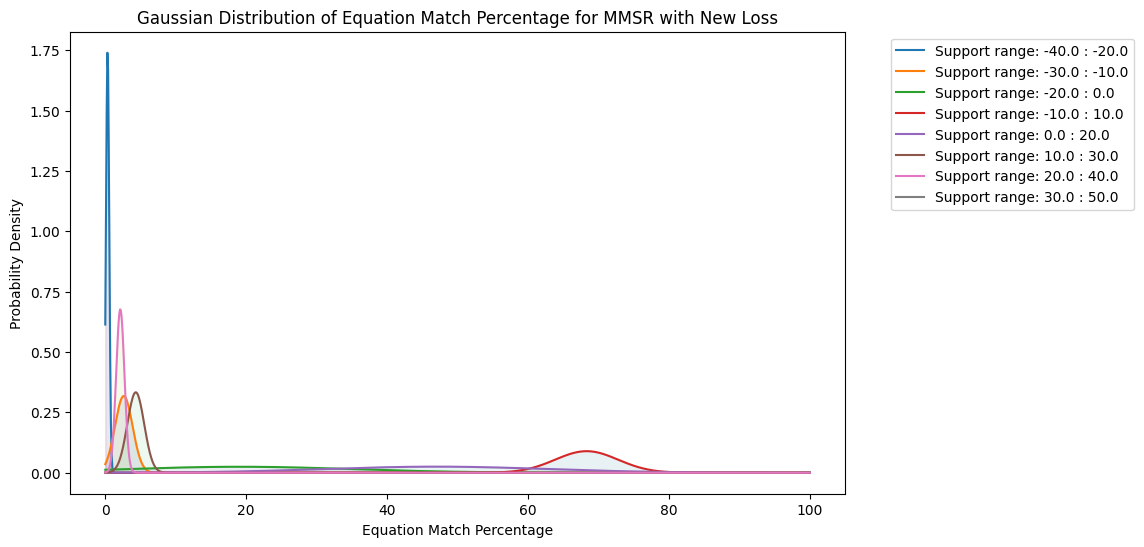

In [63]:
fig = plot_gaussian_distribution(evaluation_summary[(evaluation_summary['Model'] == 'mmsr_se5_newloss') & (evaluation_summary['Minimum Support'] % 10 == 0)], 'MMSR with New Loss')
fig.show()

In [64]:
all_models = ['mmsr_se5_newloss', 
              'mmsr_se5_oldloss', 
              'mmsr_se1_oldloss',
              #'nsr', 
              'self_trained_nsr']

models_to_compare = ['mmsr_se5_newloss', 'self_trained_nsr']

model_name_mapping = {
    'mmsr_se5_newloss': 'fancy-water-85',
    'mmsr_se5_oldloss': 'rich-flower-83',
    'mmsr_se1_oldloss': 'sage-cloud-81',
    'self_trained_nsr': 'Baseline Model',
    'nsr': 'NSR from paper'
}

In [65]:
dataframe_standard_deviaton = evaluation_summary[evaluation_summary['Model'].isin(all_models) & 
                                            (evaluation_summary['Minimum Support'] % 10 == 0) & 
                                            (evaluation_summary['Maximum Support'] - evaluation_summary['Minimum Support'] == 20) &
                                            (evaluation_summary['Number of Samples'] == 500)].copy()



dataframe_standard_deviaton['Model'] = dataframe_standard_deviaton['Model'].replace(model_name_mapping)

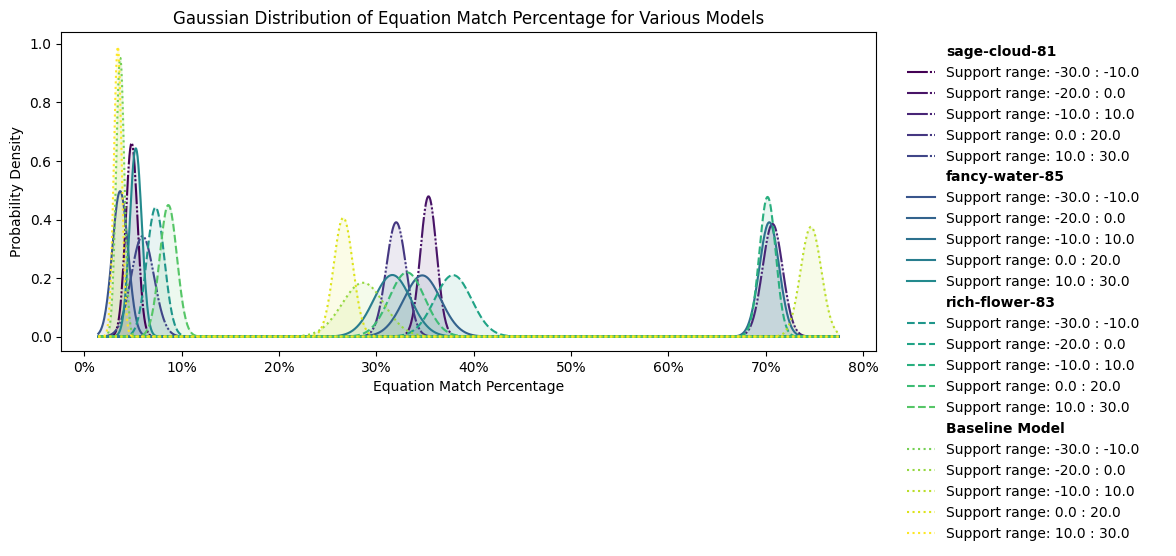

In [66]:

fig = plot_gaussian_distribution_multiple_models(dataframe_standard_deviaton)
fig.show()

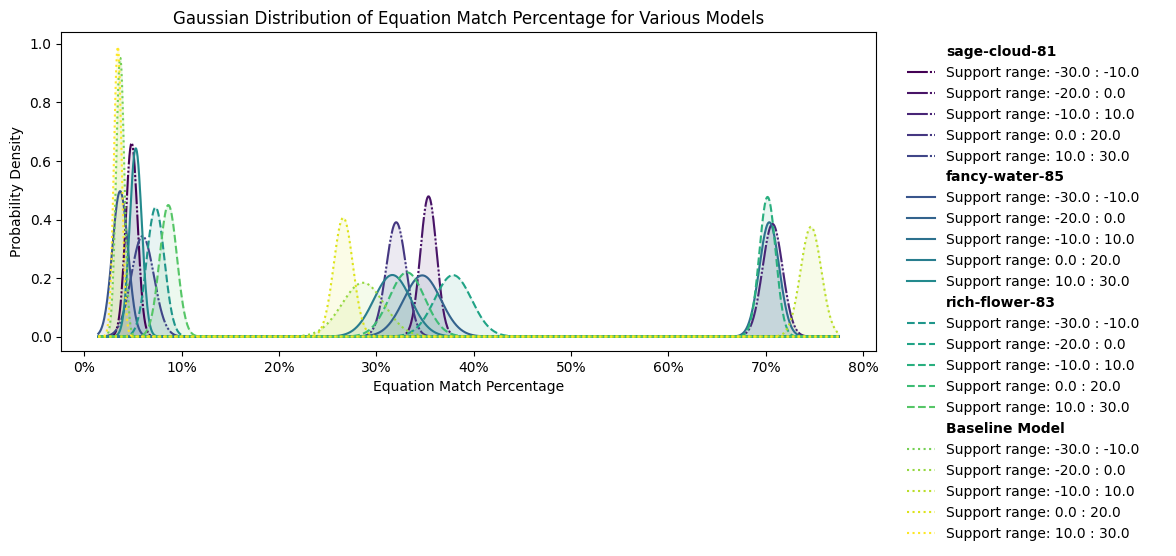

In [67]:
model_name_mapping_web_abstract = {
    'fancy-water-85': 'Self implemented model',
    'NSR': 'Baseline Model'
}
dataframe_web_abstract = dataframe_standard_deviaton

dataframe_web_abstract['Model'] = dataframe_standard_deviaton['Model'].replace(model_name_mapping)

fig = plot_gaussian_distribution_multiple_models(dataframe_web_abstract)
fig.show()

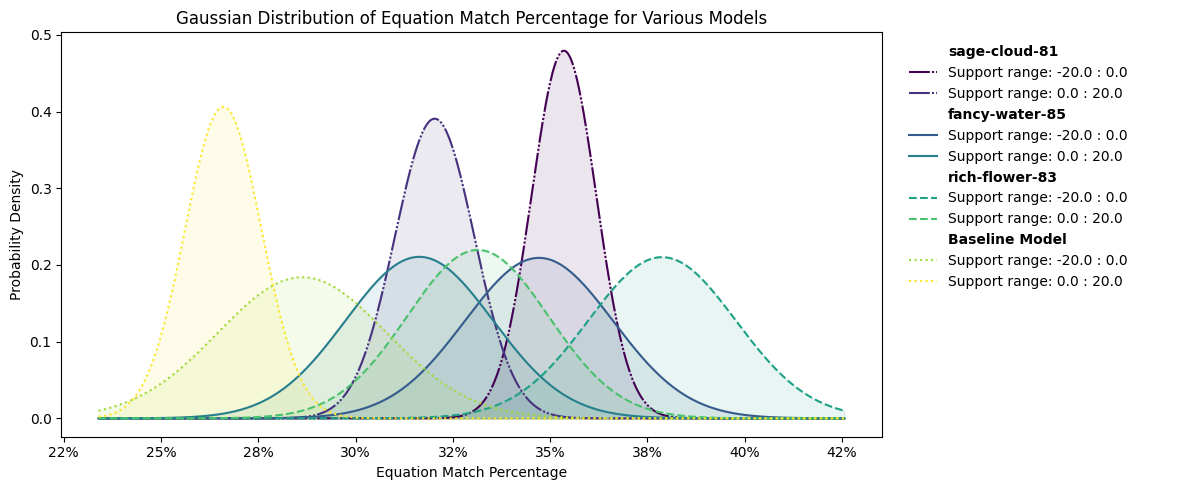

In [68]:
fig = plot_gaussian_distribution_multiple_models(dataframe_standard_deviaton[(dataframe_standard_deviaton['Minimum Support'] == -20) | 
                                                                             (dataframe_standard_deviaton['Minimum Support'] == 0)], modelname_visible=False)
fig.show()

In [69]:
mmsr_newloss_eval = evaluation_summary[evaluation_summary['Model'] == 'mmsr_se5_oldloss']
mmsr_newloss_eval.head()

,Model,Dataset,Skeleton Encoder Layers,Loss Version,Minimum Support,Maximum Support,Total Entries,Match Sum,Match Percentage,Number of Samples
1475,mmsr_se5_oldloss,train_nc,5.0,old,-40.0,-30.0,212,0,0.0,500.0
1476,mmsr_se5_oldloss,train_nc,5.0,old,-40.0,-30.0,212,0,0.0,500.0
1477,mmsr_se5_oldloss,train_nc,5.0,old,-40.0,-30.0,212,0,0.0,500.0
1478,mmsr_se5_oldloss,train_nc,5.0,old,-40.0,-30.0,214,0,0.0,500.0
1479,mmsr_se5_oldloss,train_nc,5.0,old,-40.0,-30.0,212,0,0.0,500.0


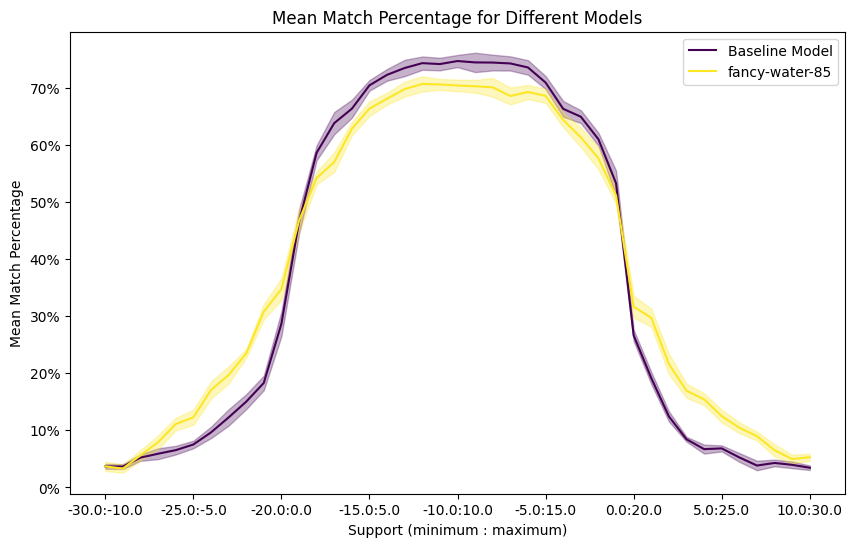

In [70]:
dataframe_mean_match_percentage = evaluation_summary[evaluation_summary['Model'].isin(models_to_compare) &  
                                            (evaluation_summary['Maximum Support'] - evaluation_summary['Minimum Support'] == 20) &
                                            (evaluation_summary['Number of Samples'] == 500)].copy()


dataframe_mean_match_percentage['Model'] = dataframe_mean_match_percentage['Model'].replace(model_name_mapping)

fig = plot_mean_match_percentage(dataframe_mean_match_percentage)
fig.show()

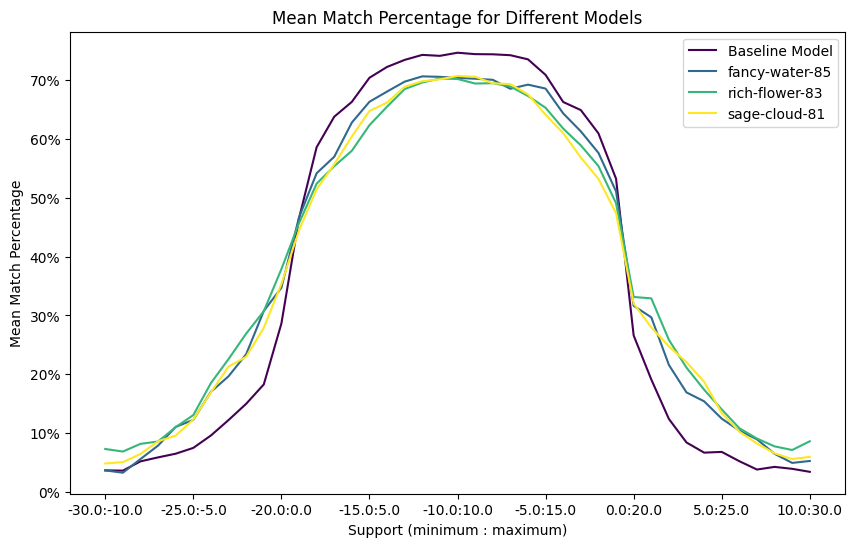

In [71]:
dataframe_mean_match_percentage = evaluation_summary[evaluation_summary['Model'].isin(all_models) &  
                                            (evaluation_summary['Maximum Support'] - evaluation_summary['Minimum Support'] == 20) &
                                            (evaluation_summary['Number of Samples'] == 500)].copy()


dataframe_mean_match_percentage['Model'] = dataframe_mean_match_percentage['Model'].replace(model_name_mapping)

fig = plot_mean_match_percentage(dataframe_mean_match_percentage, show_std_shaded=False)
fig.show()

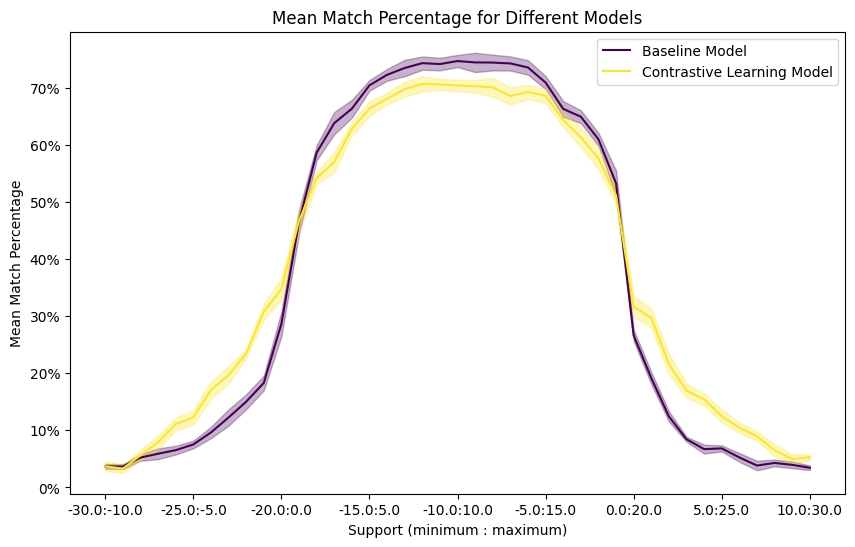

In [72]:
model_name_mapping = {
    'mmsr_se5_newloss': 'Contrastive Learning Model',
    'self_trained_nsr': 'Baseline Model',
}

dataframe_standard_deviaton = evaluation_summary[evaluation_summary['Model'].isin(models_to_compare) & 
                                            (evaluation_summary['Maximum Support'] - evaluation_summary['Minimum Support'] == 20) &
                                            (evaluation_summary['Number of Samples'] == 500)].copy()



dataframe_standard_deviaton['Model'] = dataframe_standard_deviaton['Model'].replace(model_name_mapping)

fig = plot_mean_match_percentage(dataframe_standard_deviaton)
fig.show()

In [73]:
dataframe_mean_match_percentage

dataframe_mean_match_percentage[((dataframe_mean_match_percentage['Model'] == 'NSR')) & 
                            (dataframe_mean_match_percentage['Minimum Support'] == -10) & 
                            (dataframe_mean_match_percentage['Number of Samples'] == 500) &
                            (dataframe_mean_match_percentage['Maximum Support'] == 10)]['Match Percentage'].mean()

nan

/tmp/ipykernel_2467317/4175145498.py:120: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to fit everything nicely and reduce right padding


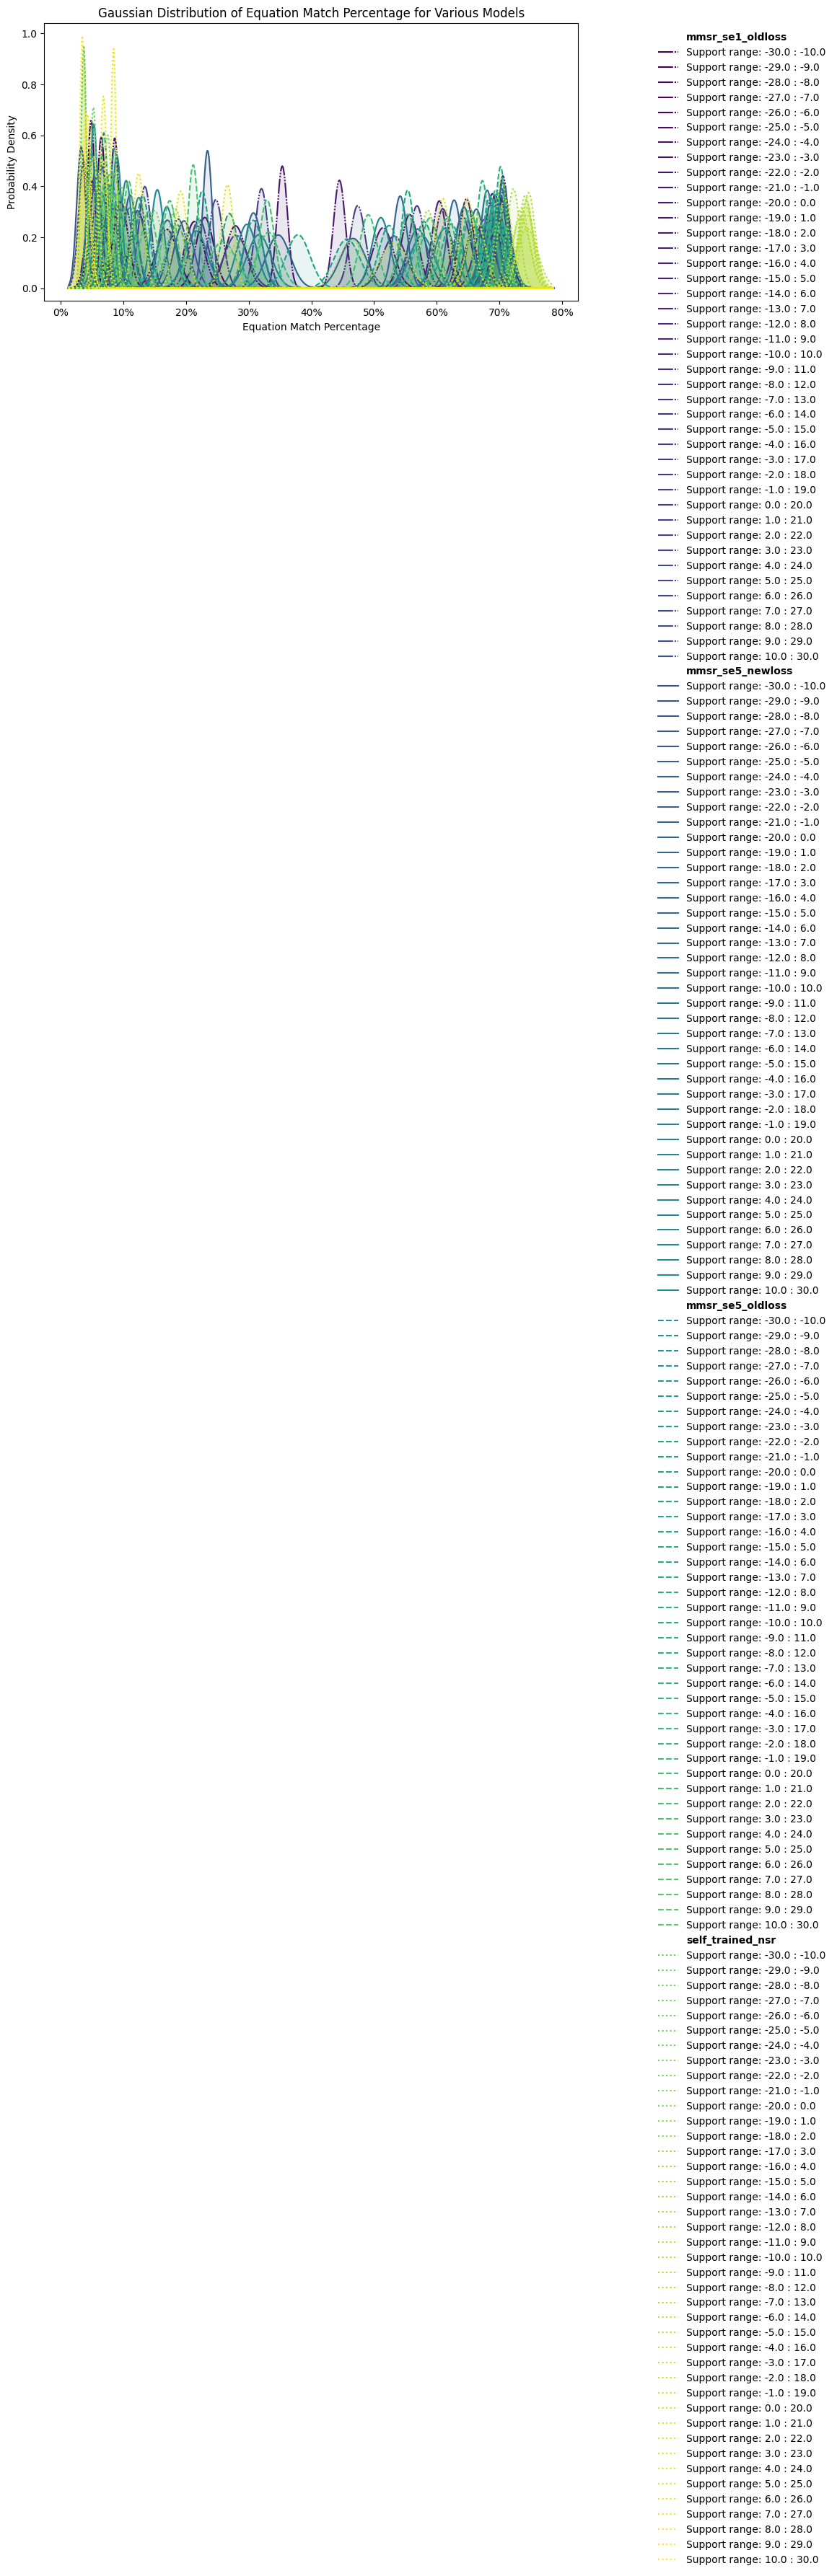

In [74]:
dataframe_standard_deviaton_all = evaluation_summary[evaluation_summary['Model'].isin(all_models) &  
                                            (evaluation_summary['Maximum Support'] - evaluation_summary['Minimum Support'] == 20) &
                                            (evaluation_summary['Number of Samples'] == 500)]


fig = plot_gaussian_distribution_multiple_models(dataframe_standard_deviaton_all)
fig.show()

In [75]:
dataframe_insight_mean_match_percentage = dataframe_meam_match_percentage.groupby(['Model', 'Minimum Support'])['Match Percentage'].mean().reset_index()

NameError: name 'dataframe_meam_match_percentage' is not defined

In [ ]:
# Pivot the DataFrame
pivot_df = dataframe_insight_mean_match_percentage.pivot(index='Minimum Support', columns='Model', values='Match Percentage')

# Calculate the differences
pivot_df = pivot_df.sub(pivot_df['fancy-water-85'], axis=0)

# Find the highest and lowest difference
highest_difference = pivot_df.max().max()
lowest_difference = pivot_df.min().min()

In [ ]:
highest_difference, lowest_difference

(6.805625757108885, -12.47263647392581)

In [ ]:
# Pivot the DataFrame
pivot_df = dataframe_insight_mean_match_percentage.pivot(index='Minimum Support', columns='Model', values='Match Percentage')

# Calculate the differences
pivot_df = pivot_df.sub(pivot_df['fancy-water-85'], axis=0)

# Drop the 'mmsr_se5_newloss' column as we don't need to compare it with itself
pivot_df = pivot_df.drop(columns=['fancy-water-85'])

# Initialize dictionaries to store the results
highest_difference = {}
lowest_difference = {}
highest_difference_min_support = {}
lowest_difference_min_support = {}

# Find the highest and lowest difference and their corresponding 'Minimum Support' for each model
for model in pivot_df.columns:
    highest_difference[model] = pivot_df[model].max()
    lowest_difference[model] = pivot_df[model].min()
    highest_difference_min_support[model] = pivot_df[pivot_df[model] == highest_difference[model]].index[0]
    lowest_difference_min_support[model] = pivot_df[pivot_df[model] == lowest_difference[model]].index[0]

In [ ]:
highest_difference

{'NSR': 6.805625757108885,
 'rich-flower-83': 4.260151700473841,
 'sage-cloud-81': 5.1384666828793755}

In [ ]:
lowest_difference

{'NSR': -12.47263647392581,
 'rich-flower-83': -4.794529125518814,
 'sage-cloud-81': -4.441778661465342}

In [ ]:
highest_difference_min_support

{'NSR': -17.0, 'rich-flower-83': 2.0, 'sage-cloud-81': 3.0}